# Publishing Figures - Single Kappa
This obtains all figures for a comparison between two simulations of neighbouring optical depth that only require the surface variables.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import decompose_temp_adiabat_anomaly, get_temp_adiabat, get_theory_prefactor_terms, \
    get_delta_mse_mod_anom_theory, do_delta_mse_mod_taylor_expansion, get_delta_temp_quant_theory_final
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2024-05-24 16:02:18,129 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [173]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'klzbs', 'convflag']        # only keep variables required to compute relative humidity and MSE


use_time_start = 360*2
pressure_ft = 500               # Desired approximate pressure of free troposphere (hPa)

# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
# refer to bucket model with vegetation as bucket
# Don't include actual bucket, as looks very similar to bucket with vegetation param
# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
exp_dir = 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'
# exp_dir = 'tau_sweep/aquaplanet/depth=1/'

# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket', 'Bucket - $C_V$']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/', 'tau_sweep/land/meridional_band/bucket/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# color_seq_exp = ['b', 'g', 'orange', 'r']

kappa_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_kappa = len(kappa_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = isca_tools.load_dataset(exp_dir + kappa_names[j]).sel(time=slice(use_time_start, np.inf))[var_keep]
        
        ds += [ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')]      # only keep the surface and free troposphere values
        namelist = isca_tools.load_namelist(exp_dir + kappa_names[j])  # Need this for albedo_value
        albedo += [namelist['mixed_layer_nml']['albedo_value']]
        tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
        tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
        pbar.update(1)
        
pfull = ds_use.pfull
ind_surf = 0
ind_ft = 1
p_surface = float(ds[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)
n_pressure = ds[0].pfull.size
lnp_const = R * np.log(p_surface/pressure_ft_actual)/2      # for modified MSE calculation

100%|██████████| 2/2 [00:03<00:00,  1.77s/it]


## Get datasets
Get one dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the all or just tbe summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [174]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

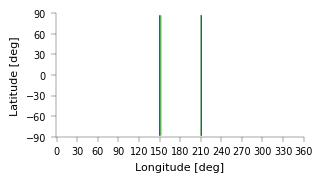

In [175]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, kappa_names[0], 'land.nc')
is_land_data = os.path.exists(land_file_name)
if is_land_data:
    fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
    isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
    lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]       # get the longitude coordinates of land
    
    if save_fig or save_land_fig:
        fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf",
                    dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [176]:
# Load in across all latitudes, for given season

# Select region to combine latitudes over for all but one of the plots below
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# lat_max = 90

# Chose whether to only consider summer days or consider all days
# season = 'all'
season = 'summer'
# season = 'winter'
if season == 'summer':
    if region == 'tropics':
        season_months = {'nh': [5, 6, 7, 8, 9, 10], 'sh': [11, 12, 1, 2, 3, 4]}   
    else:
        season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    if region == 'tropics':
        season_months = {'sh': [5, 6, 7, 8, 9, 10], 'nh': [11, 12, 1, 2, 3, 4]}
    else:
        season_months = {'sh': [6, 7, 8], 'nh': [12, 1, 2]} 

lat_use_ind = np.where((np.abs(ds[0].lat) <= lat_max) & (np.abs(ds[0].lat) >= lat_min))[0]
n_lat = len(lat_use_ind)
lat_weights = np.cos(np.deg2rad(ds[0].lat))[lat_use_ind]

# Whether to do taylor expansion about mean over just land or mean over whole planet
mean_method = 'land'
# mean_method = 'all'

temp_mean = np.zeros((n_kappa, n_pressure, n_lat))
r_mean = np.zeros((n_kappa, n_lat))          # compute mean rh as mean over rh on each day
z_mean = np.zeros((n_kappa, n_pressure, n_lat))

ds_all = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds[j].isel(lat=lat_use_ind)   # only keep latitudes being used to save memory
        
        if is_land_data:
            # if not aquaplanet, then is land and only consider land longitudes
            ds_use = ds_use.isel(lon=np.where(np.isin(ds_use.lon, np.unique(lon_land)))[0])
        
        if season == 'summer':
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(0, 90))  
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-90, 0)) 
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        
        if mean_method == 'all':
            ds_use = ds[j].sel(time=slice(use_time_start, np.inf)).isel(lat=lat_use_ind)
            ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        elif mean_method != 'land':
            raise ValueError(f'Mean method is {mean_method} which is not valid.')
        temp_mean[j] = ds_use.temp.mean(dim='lon_time')
        z_mean[j] = ds_use.height.mean(dim='lon_time')
        rh_use = ds_use.sphum.isel(pfull=ind_surf)/sphum_sat(ds_use.temp.isel(pfull=ind_surf), p_surface)
        r_mean[j] = rh_use.mean(dim='lon_time')
        pbar.update(1)
sphum_mean = r_mean * sphum_sat(temp_mean[:, ind_surf], p_surface)       # compute sphum_mean from r_mean

100%|██████████| 2/2 [00:22<00:00, 11.45s/it]


In [177]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)
percentile_label = 'Temperature percentile, $x$'

# Days must have klzb < thresh and convflag > thresh to be considered convecting.
klzb_thresh = 13
convflag_thresh = 1

# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant3 = np.zeros((n_kappa, n_pressure, n_lat, n_quant))
# relative humidity as function of temp quantile not temp quantile
r_quant3 = np.zeros((n_kappa, n_lat, n_quant))
z_quant3 = np.zeros((n_kappa, n_pressure, n_lat, n_quant))
convflag_quant3 = np.zeros((n_kappa, n_lat, n_quant))
klzbs_quant3 = np.zeros((n_kappa, n_lat, n_quant))
convfract_quant3 = np.zeros((n_kappa, n_lat, n_quant))            # record fraction of days convecting

with tqdm(total=n_kappa*n_quant*n_lat, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds_all[j]
        temp_quant3[j] = ds_use.temp.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose('pfull', 'lat', 'quantile')
        rh_use = ds_use.sphum.isel(pfull=ind_surf)/sphum_sat(ds_use.temp.isel(pfull=ind_surf), p_surface)
        is_convecting = np.logical_and(ds_use.klzbs<klzb_thresh, ds_use.convflag > convflag_thresh)
        for k in range(n_lat):
            for q, quant in enumerate(quant_plot):
                use_ind = get_quant_ind(ds_use.temp[ind_surf, k], quant, 0.5, 0.5)
                z_quant3[j, :, k, q] = ds_use.height[:, k, use_ind].mean(dim='lon_time')
                r_quant3[j, k, q] = rh_use[k, use_ind].mean(dim='lon_time')
                convflag_quant3[j, k, q] = ds_use.convflag[k, use_ind].mean(dim='lon_time')
                klzbs_quant3[j, k, q] = ds_use.klzbs[k, use_ind].mean(dim='lon_time')
                convfract_quant3[j, k, q] = np.sum(is_convecting[k, use_ind])/is_convecting[k, use_ind].size
                pbar.update(1)
sphum_quant3 = sphum_sat(temp_quant3[:, ind_surf], p_surface) * r_quant3             # compute specific humidity from relative humidity
r_anom = r_quant3 - r_mean[:, :, np.newaxis]
temp_s_anom = temp_quant3[:, ind_surf] - temp_mean[:, ind_surf, :, np.newaxis]

100%|██████████| 2772/2772 [00:07<00:00, 361.62it/s]


In [178]:
temp_adiabat_anom = np.zeros((n_kappa, n_lat, n_quant))
temp_ce_mean = np.zeros((n_kappa, n_lat))
temp_ce_quant = np.zeros((n_kappa, n_lat, n_quant))
temp_ft_anom = np.zeros((n_kappa, n_lat, n_quant))
temp_adiabat_mean = np.zeros((n_kappa, n_lat))
for j in range(n_lat):
    temp_adiabat_anom[:, j], temp_ce_mean[:, j], temp_ce_quant[:, j], temp_ft_anom[:, j] = \
        decompose_temp_adiabat_anomaly(temp_mean[:, ind_surf, j], temp_quant3[:, ind_surf, j], sphum_mean[:, j], 
                                       sphum_quant3[:, j], temp_mean[:, ind_ft, j], temp_quant3[:, ind_ft, j], 
                                       p_surface, pressure_ft_actual)
    for i in range(n_kappa):
        temp_adiabat_mean[i, j] = get_temp_adiabat(temp_mean[i, ind_surf, j], sphum_mean[i, j], p_surface, pressure_ft_actual)
temp_ce_mean_change = temp_ce_mean[1] - temp_ce_mean[0]
temp_ce_quant_change = temp_ce_quant[1] - temp_ce_quant[0]
temp_ft_anom_change = temp_ft_anom[1] - temp_ft_anom[0]
z_ft_mod_anom = (z_quant3[:, ind_ft] - z_mean[:, ind_ft][:, :, np.newaxis]) * g / lnp_const 
temp_adiabat_anom_quant3_z_form = z_ft_mod_anom + np.expand_dims(temp_ce_mean, axis=-1) - temp_ce_quant

In [179]:
# Surface MSE
mse_quant3 = moist_static_energy(temp_quant3[:, ind_surf], sphum_quant3, z_quant3[:, ind_surf])
mse_mean = moist_static_energy(temp_mean[:, ind_surf], sphum_mean, z_mean[:, ind_surf])
mse_mod_quant3 = moist_static_energy(temp_quant3[:, ind_surf], sphum_quant3, height=0, 
                                        c_p_const=c_p - lnp_const)
mse_mod_mean = moist_static_energy(temp_mean[:, ind_surf], sphum_mean, height=0, c_p_const=c_p - lnp_const)

# Free troposphere MSE
mse_ft_sat_quant3 = moist_static_energy(temp_quant3[:, ind_ft], sphum_sat(temp_quant3[:, ind_ft], pressure_ft_actual), z_quant3[:, ind_ft])
mse_ft_sat_mean = moist_static_energy(temp_mean[:, ind_ft], sphum_sat(temp_mean[:, ind_ft], pressure_ft_actual), 
                                      z_mean[:, ind_ft])
mse_mod_ft_quant3 = moist_static_energy(temp_quant3[:, ind_ft], sphum_sat(temp_quant3[:, ind_ft], pressure_ft_actual), height=0, 
                                        c_p_const=c_p + lnp_const)
mse_mod_ft_mean = moist_static_energy(temp_mean[:, ind_ft], sphum_sat(temp_mean[:, ind_ft], pressure_ft_actual), height=0, c_p_const=c_p + lnp_const)

# CQE indicator
epsilon_quant3 = mse_quant3 - mse_ft_sat_quant3
epsilon_mean = mse_mean - mse_ft_sat_mean

## Test $z$ Relation
A crucial aspect to this theory is relating the geopotential height $z_{FT}$ to near-surface temperature $T$ and free troposphere temperature $T_{FT}$.

We start with two equations, from Zhang 2023. The first combines hydrostatic balance and the ideal gas law. The second assumes a constant lapse rate, $\Gamma$, for integration processes.

$d\ln p = -\frac{g}{RT(p)}dz$;      $z(p) - z_s = \frac{T_s - T(p)}{\Gamma}$

Combining the two, we get $d\ln p = \frac{g}{R\Gamma}d\ln T$.

Integrating between the free troposphere at 500hPa and surface at 1000hPa, we get:
$\ln(\frac{1000}{500}) = \ln 2 = \frac{g}{R\Gamma}\ln(\frac{T_s}{T_{500}})$ or $\frac{1}{\Gamma} = \frac{R\ln 2}{g\ln(\frac{T_s}{T_{500}})}$

We also have the $z$ equation applied at 500hPa: $z_{500} - z_s = \frac{T_s - T_{500}}{\Gamma}$. Combining the two, we get:
$z_{500} - z_s \approx \frac{R\ln 2(T_s - T_{500})}{g\ln(\frac{T_s}{T_{500}})}$

We can re-write the denominator in $\ln(1+x)$ form as $\ln(1+\frac{T_s-T_{500}}{T_{500}})$. Here $x=\frac{T_s-T_{500}}{T_{500}}$ and is small. Max value in tropics is about 0.15. 

The taylor series is $\frac{1}{\ln(1+x)} \approx \frac{1}{x} + \frac{1}{2} - \frac{x}{12} + ...$. Because $x$ is small, I propose keeping just the first two terms. In which case, we get:

$z_{500} - z_s \approx \frac{R\ln 2(T_s - T_{500})}{g}(\frac{T_{500}}{T_s-T_{500}} + \frac{1}{2}) = \frac{R\ln 2}{2g}(T_s + T_{500})$

The plots below shows that the taylor approximation is pretty accurate, but they are both bad approximations for the actual geopotential height.

In [180]:
def get_z_theory(temp_surf, temp_ft, taylor=True, pressure_surf=p_surface, pressure_ft=pressure_ft_actual):
    lnp_prefactor = R * np.log(pressure_surf/pressure_ft) / g
    if taylor:
        return lnp_prefactor/2 * (temp_surf + temp_ft)
    else:
        return lnp_prefactor * (temp_surf - temp_ft) / np.log(temp_surf/temp_ft)

z_theory_quant3 = {key: np.zeros((n_kappa, n_lat, n_quant)) for key in ['full', 'taylor']}
z_theory_mean = {key: np.zeros((n_kappa, n_lat)) for key in ['full', 'taylor']}
for i in range(n_kappa):
    for key in z_theory_quant3:
        z_theory_quant3[key][i] = get_z_theory(temp_quant3[i, ind_surf], temp_quant3[i, ind_ft], True if key=='taylor' else False)
        z_theory_mean[key][i] = get_z_theory(temp_mean[i, ind_surf], temp_mean[i, ind_ft], True if key=='taylor' else False)

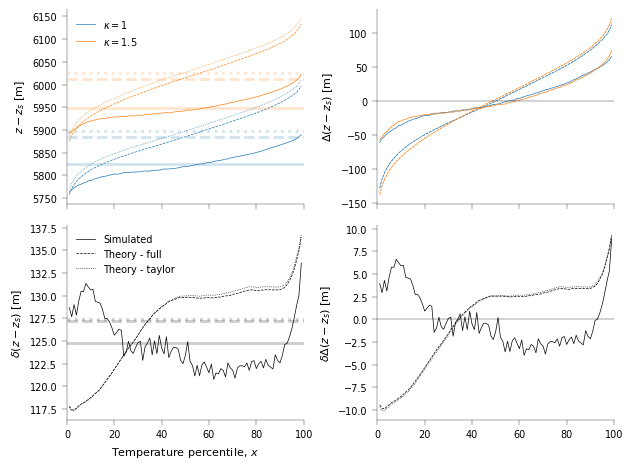

In [181]:
save_z_ft_fig = False
fig, ax = plt.subplots(2,2, figsize=(2*width['one_col'], 2*width['one_col']/ar), sharex=True)
linestyles_use = {'full': '--', 'taylor': ':'}
for i in range(n_kappa):
    ax[0, 0].plot(quant_plot, 
               np.average(z_quant3[i, ind_ft] - z_quant3[i, ind_surf], axis=0, weights=lat_weights), color=default_colors[i],
               label=f'$\\kappa={tau_lw[i]}$')
    ax[0, 0].axhline(np.average(z_mean[i, ind_ft]-z_mean[i, ind_surf], axis=0, weights=lat_weights), color=default_colors[i], lw=2, alpha=0.2)
    for key in z_theory_quant3:
        ax[0, 0].plot(quant_plot, 
                   np.average(z_theory_quant3[key][i], axis=0, weights=lat_weights), color=default_colors[i], 
                   linestyle=linestyles_use[key])
        ax[0, 0].axhline(np.average(z_theory_mean[key][i], axis=0, weights=lat_weights), color=default_colors[i], 
                      linestyle=linestyles_use[key], lw=2, alpha=0.2)
ax[1, 0].plot(quant_plot, 
           np.average(np.diff(z_quant3[:, ind_ft] - z_quant3[:, ind_surf], axis=0)[0], axis=0, weights=lat_weights), color='k',
           label='Simulated')
ax[1, 0].axhline(np.average(np.diff(z_mean[:, ind_ft]-z_mean[:, ind_surf], axis=0)[0], axis=0, weights=lat_weights), 
              color='k', lw=2, alpha=0.2)
for key in z_theory_quant3:
    ax[1, 0].plot(quant_plot, 
                   np.average(z_theory_quant3[key][1]-z_theory_quant3[key][0], axis=0, weights=lat_weights), 
               color='k', linestyle=linestyles_use[key], label=f'Theory - {key}')
    ax[1, 0].axhline(np.average(z_theory_mean[key][1]-z_theory_mean[key][0], axis=0, weights=lat_weights), color='k', 
                  linestyle=linestyles_use[key], lw=2, alpha=0.2)

for i in range(n_kappa):
    ax[0, 1].plot(quant_plot, 
               np.average(z_quant3[i, ind_ft] - z_quant3[i, ind_surf] - (z_mean[i, ind_ft]-z_mean[i, ind_surf])[:, np.newaxis], 
                          axis=0, weights=lat_weights), color=default_colors[i], label=f'$\\kappa={tau_lw[i]}$')
    for key in z_theory_quant3:
        ax[0, 1].plot(quant_plot, np.average(z_theory_quant3[key][i] - z_theory_mean[key][i][:, np.newaxis], axis=0, weights=lat_weights),
                      color=default_colors[i], linestyle=linestyles_use[key])
ax[1, 1].plot(quant_plot, 
           np.average(np.diff(z_quant3[:, ind_ft] - z_quant3[:, ind_surf] - (z_mean[:, ind_ft]-z_mean[:, ind_surf])[:, :, np.newaxis], axis=0)[0], 
                      axis=0, weights=lat_weights), color='k')
for key in z_theory_quant3:
    ax[1, 1].plot(quant_plot, 
                   np.average(z_theory_quant3[key][1]-z_theory_quant3[key][0] - (z_theory_mean[key][1]-z_theory_mean[key][0])[:, np.newaxis], 
                              axis=0, weights=lat_weights), color='k', linestyle=linestyles_use[key], label=f'Theory - {key}') 

ax[0, 0].legend()
ax[1, 0].legend()
ax[0, 0].set_ylabel('$z-z_s$ [m]')
ax[0, 1].set_ylabel('$\Delta (z-z_s)$ [m]')
ax[1, 0].set_ylabel('$\delta (z-z_s)$ [m]')
ax[1, 1].set_ylabel('$\delta \Delta (z-z_s)$ [m]')
ax[1, 0].set_xlabel(percentile_label)
ax[0, 0].set_xlim(0, 100)
ax[0, 1].axhline(0, color='k', lw=ax_linewidth)
ax[1, 1].axhline(0, color='k', lw=ax_linewidth)
plt.tight_layout()
if save_fig or save_z_ft_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/land_z_ft_approx_{region}_{season}.pdf",
                                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## $\delta \Delta h_s^{\dagger}$ Approximation 1
To get a theoretical estimate of $\delta T_s(x)$, we need to do an expansion of $\delta \Delta h_s^{\dagger}$ in terms of $\Delta T_A$ and $\delta \Delta T_A$.

Below, we see how the accuracy of the $\delta \Delta h_s^{\dagger}$ approximation impacts on the $\delta T_s(x)$ prediction.

In [182]:
def scale_factor_theory_no_taylor_fit_func(scale_factor, temp_surf_mean, temp_surf_quant0, r_surf_mean, r_surf_quant, temp_ft_mean, temp_ft_quant, 
                                 z_surf_mean = None, z_surf_quant = None, z_ft_quant = None, z_ft_mean = None, epsilon_mean = None, 
                                 epsilon_quant = None, pressure_surf: float = p_surface, pressure_ft: float = pressure_ft_actual) -> float:
    # Finds scaling factor such that mse_s_quant - mse_s_mean = mse_ft_quant - mse_ft_mean + epsilon_quant - epsilon_mean
    # If z is not given, will assume z relation to temperature
    # If epsilon_mean not given, will assume CQE i.e. no change in epsilon anomaly with warming
    # Epsilon is in kJ/kg
    n_exp = len(r_surf_mean)
    temp_mean_change = temp_surf_mean[1] - temp_surf_mean[0]
    temp_quant_hot = temp_surf_quant0 + scale_factor * temp_mean_change
    
    if z_surf_mean is None:
        # Assume relation between z and temp
        z_surf_mean = np.zeros(n_exp)
        z_surf_quant = np.zeros(n_exp)
        z_ft_mean = np.zeros(n_exp)
        z_ft_quant = np.zeros(n_exp)
        c_p_const_surf = c_p - lnp_const
        c_p_const_ft = c_p + lnp_const
    else:
        c_p_const_surf = c_p
        c_p_const_ft = c_p
    
    mse_surf_quant_cold = moist_static_energy(temp_surf_quant0, r_surf_quant[0] * sphum_sat(temp_surf_quant0, pressure_surf), z_surf_quant[0],
                                              c_p_const=c_p_const_surf)
    mse_surf_quant_hot = moist_static_energy(temp_quant_hot, r_surf_quant[1] * sphum_sat(temp_quant_hot, pressure_surf), z_surf_quant[1], 
                                             c_p_const=c_p_const_surf)
    mse_surf_mean = [moist_static_energy(temp_surf_mean[i], r_surf_mean[i] * sphum_sat(temp_surf_mean[i], pressure_surf), z_surf_mean[i], 
                                         c_p_const=c_p_const_surf) 
                     for i in range(n_exp)]
    mse_ft_quant = [moist_static_energy(temp_ft_quant[i], sphum_sat(temp_ft_quant[i], pressure_ft), z_ft_quant[i], c_p_const=c_p_const_ft) 
                     for i in range(n_exp)]
    mse_ft_mean = [moist_static_energy(temp_ft_mean[i], sphum_sat(temp_ft_mean[i], pressure_ft), z_ft_mean[i], c_p_const=c_p_const_ft) 
                     for i in range(n_exp)]
    mse_surf_quant_change = mse_surf_quant_hot - mse_surf_quant_cold
    mse_surf_mean_change = mse_surf_mean[1] - mse_surf_mean[0]
    mse_ft_quant_change = mse_ft_quant[1] - mse_ft_quant[0]
    mse_ft_mean_change = mse_ft_mean[1] - mse_ft_mean[0]
    if epsilon_mean is not None:
        epsilon_quant_change = epsilon_quant[1] - epsilon_quant[0]
        epsilon_mean_change = epsilon_mean[1] - epsilon_mean[0]
    else:
        epsilon_quant_change = 0
        epsilon_mean_change = 0
    return mse_surf_quant_change - mse_surf_mean_change - (mse_ft_quant_change - mse_ft_mean_change) - (epsilon_quant_change - 
                                                                                                        epsilon_mean_change)

def scale_factor_theory_from_mse_anom_change_fit_func(scale_factor, temp_surf_mean, temp_surf_quant, r_surf_mean, r_surf_quant, 
                                                      mse_mod_anom_change, pressure_surf: float = p_surface):
    # mse_mod_anom_change is in kJ/kg
    n_exp = len(r_surf_mean)
    temp_mean_change = temp_surf_mean[1] - temp_surf_mean[0]
    temp_quant_hot = temp_surf_quant[0] + scale_factor * temp_mean_change
    mse_surf_quant_cold = moist_static_energy(temp_surf_quant[0], r_surf_quant[0] * sphum_sat(temp_surf_quant[0], pressure_surf), 0,
                                              c_p_const=c_p - lnp_const)
    mse_surf_quant_hot = moist_static_energy(temp_quant_hot, r_surf_quant[1] * sphum_sat(temp_quant_hot, pressure_surf), 0, 
                                             c_p_const=c_p - lnp_const)
    mse_surf_mean = [moist_static_energy(temp_surf_mean[i], r_surf_mean[i] * sphum_sat(temp_surf_mean[i], pressure_surf), 0, 
                                         c_p_const=c_p - lnp_const) 
                     for i in range(n_exp)]
    mse_mod_anom_change_from_sf = mse_surf_quant_hot - mse_surf_quant_cold - (mse_surf_mean[1] - mse_surf_mean[0])
    return mse_mod_anom_change_from_sf - mse_mod_anom_change

def scale_factor_theory_taylor_fit_func(scale_factor, temp_surf_mean, temp_surf_quant, r_surf_mean, r_surf_quant, 
                                        mse_mod_anom_change_from_temp_a, taylor_terms='linear', pressure_surf = p_surface, 
                                        pressure_ft=pressure_ft_actual, temp_use_rh_term=None):
    # Makes same taylor series approximation for both ways of getting mse_anom_change
    temp_mean_change = temp_surf_mean[1] - temp_surf_mean[0]
    temp_surf_quant_use = np.asarray([temp_surf_quant[0], temp_surf_quant[0] + scale_factor * temp_mean_change], dtype=np.float64)
    
    sphum_mean = r_surf_mean * sphum_sat(temp_surf_mean, pressure_surf)
    sphum_quant = r_surf_quant * sphum_sat(temp_surf_quant_use, pressure_surf)
    
    mse_quant_change_from_temp_s = do_delta_mse_mod_taylor_expansion(temp_surf_quant_use[:, np.newaxis], sphum_quant[:, np.newaxis], 
                                                                     pressure_surf, pressure_ft, taylor_terms=taylor_terms, 
                                                                     temp_use_rh_term=temp_use_rh_term)[0]
    mse_mean_change_from_temp_s = do_delta_mse_mod_taylor_expansion(temp_surf_mean, sphum_mean, 
                                                                     pressure_surf, pressure_ft, taylor_terms=taylor_terms)[0]
    mse_anom_change_from_temp_s = mse_quant_change_from_temp_s - mse_mean_change_from_temp_s
    return mse_mod_anom_change_from_temp_a - mse_anom_change_from_temp_s

In [183]:
mse_mod_anom_change_simulated = mse_mod_quant3[1] - mse_mod_mean[1, :, np.newaxis] - (mse_mod_quant3[0] - mse_mod_mean[0, :, np.newaxis])
mse_mod_anom_change_theory = {key: np.zeros((n_lat, n_quant)) for key in ['t_a_linear', 't_a_non_linear', 't_a_squared']}
for key in ['t_a_linear', 't_a_non_linear', 't_a_squared']:
    for i in range(n_lat):
        mse_mod_anom_change_theory[key][i] = get_delta_mse_mod_anom_theory(temp_mean[:, ind_surf, i], temp_quant3[:, ind_surf, i], 
                                                                           sphum_mean[:, i], sphum_quant3[:, i], p_surface, pressure_ft_actual,
                                                                           taylor_terms=key.replace('t_a_', ''))[0]

In [184]:
sf_denom = (temp_mean[1, ind_surf] - temp_mean[0, ind_surf])[:, np.newaxis]
sf_simulated = (temp_quant3[1, ind_surf] - temp_quant3[0, ind_surf]) / sf_denom
sf_theory = {key: np.zeros((n_lat, n_quant)) for key in ['just_z', 't_a_linear', 't_a_non_linear', 't_a_squared']}
for i in range(n_lat):
    for j in range(n_quant):
        sf_theory['just_z'][i, j] = \
            scipy.optimize.fsolve(scale_factor_theory_no_taylor_fit_func, 1, 
                                  args=(temp_mean[:, ind_surf, i], temp_quant3[0, ind_surf, i, j], r_mean[:, i], 
                                        r_quant3[:, i, j], temp_mean[:, ind_ft, i], temp_quant3[:, ind_ft, i, j], 
                                        None, None, None, None, epsilon_mean[:, i], epsilon_quant3[:, i, j]))
        for key in mse_mod_anom_change_theory:
            sf_theory[key][i, j] = scipy.optimize.fsolve(scale_factor_theory_from_mse_anom_change_fit_func, 1, 
                                      args=(temp_mean[:, ind_surf, i], temp_quant3[:, ind_surf, i, j], r_mean[:, i], 
                                            r_quant3[:, i, j], mse_mod_anom_change_theory[key][i, j]))

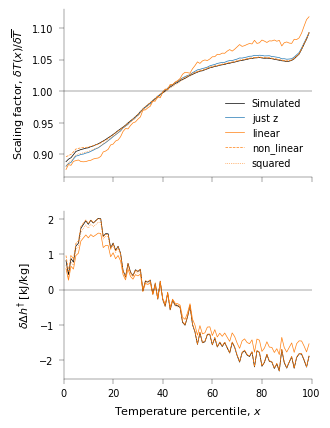

In [185]:
linestyles_sf_theory = {'linear': '-', 'non_linear': '--', 'squared': ':'}

save_delta_temp_theory_fig2 = False
fig_sf_theory, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
ax[0].plot(quant_plot, np.average(sf_simulated, weights=lat_weights, axis=0), color='k',
           label='Simulated')
ax[0].plot(quant_plot, np.average(sf_theory['just_z'], weights=lat_weights, axis=0), color=default_colors[0],
           label='just z')
for i, key in enumerate(mse_mod_anom_change_theory):
    if 't_a' not in key:
        continue
    ax[0].plot(quant_plot, np.average(sf_theory[key], weights=lat_weights, axis=0), color=default_colors[1], 
               linestyle=linestyles_sf_theory[key.replace('t_a_', '')], label=key.replace('t_a_', ''))
    
ax[1].plot(quant_plot, np.average(mse_mod_anom_change_simulated, axis=0, weights=lat_weights), color='k', label='Simulated')
for i, key in enumerate(mse_mod_anom_change_theory):
    if 't_a' not in key:
        continue
    ax[1].plot(quant_plot, np.average(mse_mod_anom_change_theory[key], axis=0, weights=lat_weights), 
               label=key.replace('t_a', ''), linestyle=linestyles_sf_theory[key.replace('t_a_', '')], color=default_colors[1])
ax[0].legend()
ax[0].set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
ax[1].set_ylabel('$\delta \Delta h^{\dagger}$ [kJ/kg]')
ax[0].axhline(1, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)

if save_fig or save_delta_temp_theory_fig2:
    fig_sf_theory.savefig(f"/Users/joshduffield/Desktop/land_sf_theory_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## $\delta \Delta h_s^{\dagger}$ Approximation 2
To get a theoretical estimate of $\delta T_s(x)$, we also need to do an expansion of $\delta h_s^{\dagger}(x)$ in terms of $\delta T_s(x)$, $\delta r_s(x)$ and similar for the mean.

Below, we see how the accuracy of this $\delta \Delta h_s^{\dagger}$ approximation impacts on the $\delta T_s(x)$ prediction.

In [186]:
mse_mod_quant_change_t_s_approx = {key: np.zeros((n_lat, n_quant)) for key in ['linear', 'non_linear', 'squared']}
mse_mod_mean_change_t_s_approx = {key: np.zeros(n_lat) for key in ['linear', 'non_linear', 'squared']}
for key in mse_mod_quant_change_t_s_approx:
    for i in range(n_lat):
        mse_mod_quant_change_t_s_approx[key][i] = do_delta_mse_mod_taylor_expansion(temp_quant3[:, ind_surf, i], sphum_quant3[:, i], 
                                                                                    p_surface, pressure_ft_actual, taylor_terms=key, temp_use_rh_term=temp_mean[0, ind_surf, i])[0]
        mse_mod_mean_change_t_s_approx[key][i] = do_delta_mse_mod_taylor_expansion(temp_mean[:, ind_surf, i], sphum_mean[:, i], 
                                                                                   p_surface, pressure_ft_actual, taylor_terms=key)[0]
for key in mse_mod_quant_change_t_s_approx:
    mse_mod_anom_change_theory['t_s_'+key] = mse_mod_quant_change_t_s_approx[key] - mse_mod_mean_change_t_s_approx[key][:, np.newaxis]

for key in mse_mod_quant_change_t_s_approx:
    sf_theory['t_s_'+key] = np.zeros((n_lat, n_quant))
    for i in range(n_lat):
        for j in range(n_quant):
            sf_theory['t_s_'+key][i, j] = scipy.optimize.fsolve(scale_factor_theory_from_mse_anom_change_fit_func, 1, 
                                                                args=(temp_mean[:, ind_surf, i], temp_quant3[:, ind_surf, i, j], r_mean[:, i], 
                                                                      r_quant3[:, i, j], mse_mod_anom_change_theory['t_s_'+key][i, j]))

Text(0, 0.5, '$\\delta h^{\\dagger}$ [kJ/kg]')

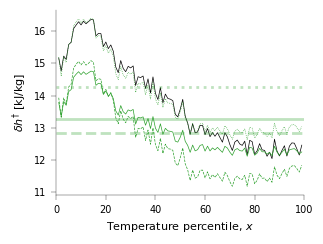

In [187]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quant_plot, np.average(mse_mod_quant3[1]-mse_mod_quant3[0], axis=0, weights=lat_weights), color='k')
for key in mse_mod_quant_change_t_s_approx:
    ax.plot(quant_plot, np.average(mse_mod_quant_change_t_s_approx[key], axis=0, weights=lat_weights), color=default_colors[2], 
            linestyle=linestyles_sf_theory[key])
    ax.axhline(np.average(mse_mod_mean_change_t_s_approx[key], axis=0, weights=lat_weights), linestyle=linestyles_sf_theory[key], 
               color=default_colors[2], lw=2, alpha=0.3)
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)
ax.set_ylabel('$\delta h^{\dagger}$ [kJ/kg]')

### Combine $T_s$ and $T_A$ approximations for $\delta \Delta h_s^{\dagger}$
Below, I combine relative degrees of approximations for both $\delta \Delta h_s^{\dagger}$ expansions to get a estimate for $\delta T_s(x)$. This is shown by the red lines.

In [188]:
for key in ['linear', 'non_linear', 'squared']:
    sf_theory[key] = np.zeros((n_lat, n_quant))
    for i in range(n_lat):
        mse_mod_anom_change_use = get_delta_mse_mod_anom_theory(temp_mean[:, ind_surf, i], temp_quant3[:, ind_surf, i], 
                                                                           sphum_mean[:, i], sphum_quant3[:, i], p_surface, pressure_ft_actual,
                                                                           taylor_terms=key,
                                                                mse_mod_mean_change=mse_mod_mean_change_t_s_approx['linear'][i]*1000)[0]
        # print(key + ' ' +str(np.max(np.abs(mse_mod_anom_change_use - mse_mod_anom_change_theory['t_a_'+key][i]))))
        for j in range(n_quant):
            sf_theory[key][i, j] = scipy.optimize.fsolve(scale_factor_theory_taylor_fit_func, 1, 
                                                         args=(temp_mean[:, ind_surf, i], temp_quant3[:, ind_surf, i, j], r_mean[:, i], 
                                                               r_quant3[:, i, j], mse_mod_anom_change_use[j], key))

/var/folders/7_/l8blmzys4m95r6r44gy_r4gh0000gn/T/ipykernel_39390/3932726364.py:69: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  temp_surf_quant_use = np.asarray([temp_surf_quant[0], temp_surf_quant[0] + scale_factor * temp_mean_change], dtype=np.float64)
/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


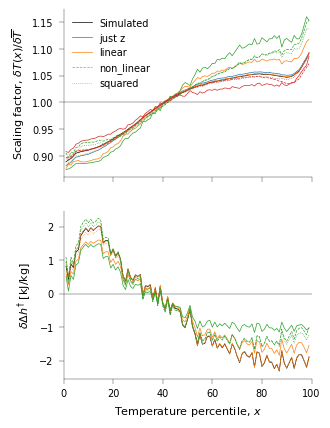

In [189]:
save_delta_temp_theory_fig3 = False
fig = copy.deepcopy(fig_sf_theory)
ax = fig.axes
for i, key in enumerate(mse_mod_anom_change_theory):
    if 't_s' not in key:
        continue
    ax[0].plot(quant_plot, np.average(sf_theory[key], weights=lat_weights, axis=0), color=default_colors[2], 
               linestyle=linestyles_sf_theory[key.replace('t_s_', '')])
    ax[1].plot(quant_plot, np.average(mse_mod_anom_change_theory[key], axis=0, weights=lat_weights), 
               linestyle=linestyles_sf_theory[key.replace('t_s_', '')], color=default_colors[2])
ax[0].plot(quant_plot, np.average(sf_theory['linear'], axis=0, weights=lat_weights), color=default_colors[3])
ax[0].plot(quant_plot, np.average(sf_theory['non_linear'], axis=0, weights=lat_weights), color=default_colors[3], linestyle='--')
ax[0].plot(quant_plot, np.average(sf_theory['squared'], axis=0, weights=lat_weights), color=default_colors[3], linestyle=':')
if save_fig or save_delta_temp_theory_fig3:
    fig.savefig(f"/Users/joshduffield/Desktop/land_sf_theory2_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)
fig

### RH Change MSE contribution
In the theory for $\delta T_s(x)$, there is a $L_v q_s^*\delta \overline{r_s} - L_v q_s^*(x) \delta r_s(x)$ term. Below we check if we can approximate this.

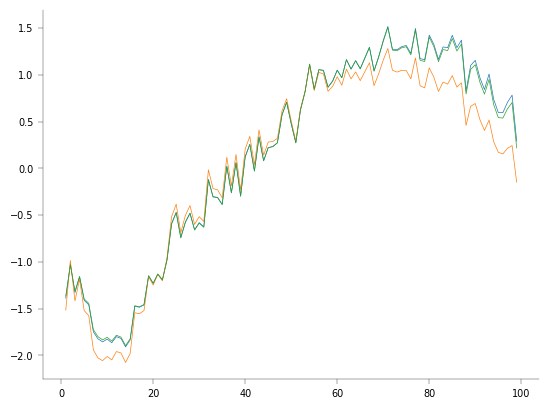

In [190]:
q_sat_s = sphum_sat(temp_mean[0, ind_surf], p_surface)
alpha_s = clausius_clapeyron_factor(temp_mean[0, ind_surf], p_surface)
r_change_mse_cont = ((L_v * q_sat_s * (r_mean[1] - r_mean[0]))[:, np.newaxis] - 
                    L_v * sphum_sat(temp_quant3[0, ind_surf], p_surface)  * (r_quant3[1] - r_quant3[0]))/1000
r_change_mse_cont_term1 = L_v * q_sat_s[:, np.newaxis] * ((r_mean[1] - r_mean[0])[:, np.newaxis] - (r_quant3[1] - r_quant3[0]))/1000
r_change_mse_cont_term2 = -L_v * (q_sat_s * alpha_s)[:, np.newaxis] * \
                          (r_mean[1]-r_mean[0])[:, np.newaxis] * (temp_quant3[0, ind_surf] - temp_mean[0, ind_surf, :, np.newaxis])/1000
r_change_mse_cont_term3 = -L_v * (q_sat_s * alpha_s)[:, np.newaxis] * (
        r_quant3[1] - r_quant3[0] - (r_mean[1]-r_mean[0])[:, np.newaxis]) * (temp_quant3[0, ind_surf] - temp_mean[0, ind_surf, :, np.newaxis])/1000
plt.plot(quant_plot, np.average(r_change_mse_cont, axis=0, weights=lat_weights))
plt.plot(quant_plot, np.average(r_change_mse_cont_term1, 
                                axis=0, weights=lat_weights))
plt.plot(quant_plot, np.average(r_change_mse_cont_term1+r_change_mse_cont_term2+r_change_mse_cont_term3, axis=0, weights=lat_weights))

## Check out current linear theory
Below I plot the breakdown of the current linear theory applied to land.

In [191]:
delta_temp_theory = {key: np.zeros((n_lat, n_quant)) for key in ['wtg', 'wtg_non_linear', 'epsilon', 'epsilon_non_linear']}
delta_temp_theory_prefactors = {'epsilon': {key: np.zeros((n_lat, n_quant)) for key in ['temp_s', 'humidity', 'conv', 
                                                                                        'r_change', 'temp_ft_change', 'conv_change']}}
delta_temp_theory_changes = copy.deepcopy(delta_temp_theory_prefactors)
delta_temp_theory_cont = copy.deepcopy(delta_temp_theory_prefactors)
for j in range(n_lat):
    delta_temp_theory['epsilon'][j], info_coef, info_change, _ = \
        get_delta_temp_quant_theory_final(temp_mean[:, ind_surf, j], temp_quant3[:, ind_surf, j], sphum_mean[:, j], 
                                          sphum_quant3[:, j], p_surface, pressure_ft_actual, 
                                          temp_mean[:, ind_ft, j], temp_quant3[:, ind_ft, j], z_mean[:, ind_ft, j], 
                                          z_quant3[:, ind_ft, j], epsilon_form=True, include_squared_terms=False)
    delta_temp_theory['epsilon_non_linear'][j] = \
        get_delta_temp_quant_theory_final(temp_mean[:, ind_surf, j], temp_quant3[:, ind_surf, j], sphum_mean[:, j], 
                                          sphum_quant3[:, j], p_surface, pressure_ft_actual, 
                                          temp_mean[:, ind_ft, j], temp_quant3[:, ind_ft, j], z_mean[:, ind_ft, j], 
                                          z_quant3[:, ind_ft, j], epsilon_form=True, include_squared_terms=True)[0]
    delta_temp_theory['wtg'][j] = \
        get_delta_temp_quant_theory_final(temp_mean[:, ind_surf, j], temp_quant3[:, ind_surf, j], sphum_mean[:, j], 
                                          sphum_quant3[:, j], p_surface, pressure_ft_actual, 
                                          temp_mean[:, ind_ft, j], temp_quant3[:, ind_ft, j], z_mean[:, ind_ft, j], 
                                          z_quant3[:, ind_ft, j], epsilon_form=False, include_squared_terms=False)[0]
    delta_temp_theory['wtg_non_linear'][j] = \
        get_delta_temp_quant_theory_final(temp_mean[:, ind_surf, j], temp_quant3[:, ind_surf, j], sphum_mean[:, j], 
                                          sphum_quant3[:, j], p_surface, pressure_ft_actual, 
                                          temp_mean[:, ind_ft, j], temp_quant3[:, ind_ft, j], z_mean[:, ind_ft, j], 
                                          z_quant3[:, ind_ft, j], epsilon_form=False, include_squared_terms=True)[0]
    for var in delta_temp_theory_prefactors['epsilon']:
        delta_temp_theory_prefactors['epsilon'][var][j] = info_coef[var]
        delta_temp_theory_changes['epsilon'][var][j] = info_change[var]
        delta_temp_theory_cont['epsilon'][var][j] = info_coef[var] * info_change[var]

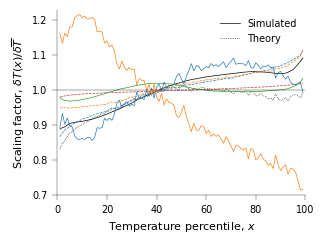

In [192]:
exp_new_plot = 'epsilon'

colors_breakdown = {'temp_s': default_colors[3], 'humidity': default_colors[0],  
                    'r_change': default_colors[0], 'conv': default_colors[1],
                    'conv_change': default_colors[1], 'temp_ft_change': default_colors[2]}
linestyles_breakdown = {key: '-' if 'change' in key else '--' for key in colors_breakdown}

save_sf_theory_breakdown_new_fig2 = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax = [ax]
ax[0].plot(quant_plot, np.average((temp_quant3[1, ind_surf] - temp_quant3[0, ind_surf])/sf_denom, weights=lat_weights, axis=0), 
           color='k', label='Simulated')
ax[0].plot(quant_plot, np.average(delta_temp_theory[exp_new_plot]/sf_denom, axis=0, weights=lat_weights), color='k', linestyle=':', label='Theory')
for key in delta_temp_theory_cont[exp_new_plot]:
    if 'temp_a' in key:
        continue
    # if 'epsilon' in key:
    #     continue
    # if key not in ['temp_s', 'humidity', 'r_change', 'temp_ft_change']:
    #     continue
    ax[0].plot(quant_plot, np.average(delta_temp_theory_cont[exp_new_plot][key]/sf_denom, weights=lat_weights, axis=0)+1,
               color=colors_breakdown[key], linestyle=linestyles_breakdown[key])
for i in range(len(ax)):
    ax[i].axhline(1, color='k', lw=ax_linewidth)
    ax[i].set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
    ax[i].legend()
ax[0].set_xlim(0,100)
ax[-1].set_xlabel(percentile_label)
ax[0].set_ylim(0.7, 1.23)

if save_fig or save_sf_theory_breakdown_new_fig2:
    file_name = f"sf_breakdown_{exp_new_plot}_{region.lower()}_{season}"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}.pdf",dpi=dpi['combination'] if publish_fig else low_dpi, 
                bbox_inches='tight', pad_inches=save_pad_inches)

## Compare Theories with and without Additive form
The blue lines below perform further taylor expansions to put equation for $\frac{\delta T_s(x)}{\delta \overline{T_s}}$ in additive form i.e. all mechanism sum together. These are compared to the harder to interpret red lines where it is harder to isolate different mechanisms.

As with other plots, solid lines are linear expansions and dashed include non-linear terms.

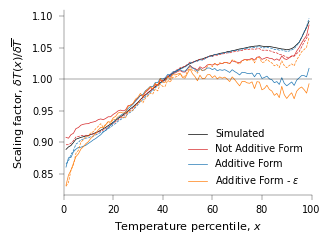

In [193]:
save_delta_temp_theory_additive_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quant_plot, np.average((temp_quant3[1, ind_surf] - temp_quant3[0, ind_surf])/sf_denom, weights=lat_weights, axis=0), 
        color='k', label='Simulated')
ax.plot(quant_plot, np.average(sf_theory['linear'], axis=0, weights=lat_weights), color=default_colors[3], label='Not Additive Form')
ax.plot(quant_plot, np.average(sf_theory['non_linear'], axis=0, weights=lat_weights), color=default_colors[3], linestyle='--')
ax.plot(quant_plot, np.average(delta_temp_theory['wtg']/sf_denom, axis=0, weights=lat_weights), color=default_colors[0], label='Additive Form')
ax.plot(quant_plot, np.average(delta_temp_theory['wtg_non_linear']/sf_denom, axis=0, weights=lat_weights), color=default_colors[0], linestyle='--')
ax.plot(quant_plot, np.average(delta_temp_theory['epsilon']/sf_denom, axis=0, weights=lat_weights), color=default_colors[1], 
        label='Additive Form - $\epsilon$')
ax.plot(quant_plot, np.average(delta_temp_theory['epsilon_non_linear']/sf_denom, axis=0, weights=lat_weights), color=default_colors[1]
        , linestyle='--')
ax.legend()
ax.set_xlabel(percentile_label)
ax.axhline(1, color='k', lw=ax_linewidth)
ax.set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
ax.set_xlim(0, 100)

if save_fig or save_delta_temp_theory_additive_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/land_sf_theory_additive_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

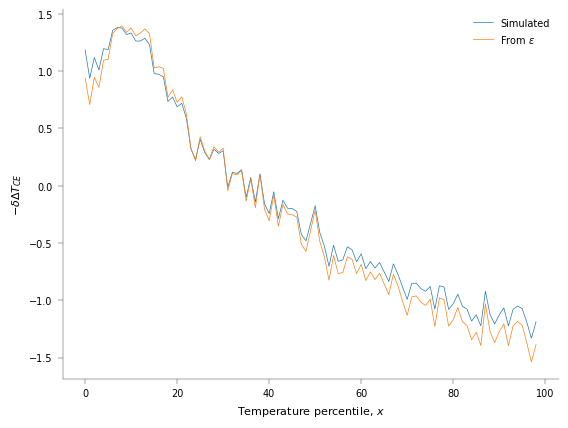

In [194]:
_, _, _, beta_s1, beta_s2, _ = get_theory_prefactor_terms(temp_mean[0, ind_surf], p_surface, pressure_ft_actual, sphum_mean[0])
_, _, _, beta_a1, beta_a2, beta_a3 = get_theory_prefactor_terms(temp_adiabat_mean[0], p_surface, pressure_ft_actual)
temp_ce_anom_change_theory = np.diff(epsilon_quant3-epsilon_mean[:, :, np.newaxis], axis=0)[0] * 1000/beta_a1[:, np.newaxis] - \
                             (beta_a2 * beta_s1 / beta_a1**3)[:, np.newaxis] * (
                                     epsilon_quant3-epsilon_mean[:, :, np.newaxis])[0] * 1000/temp_adiabat_mean[0, :, np.newaxis] * sf_denom
plt.plot(np.average(temp_ce_mean_change[:, np.newaxis] - temp_ce_quant_change, axis=0, weights=lat_weights), label='Simulated')
plt.plot(np.average(temp_ce_anom_change_theory, axis=0, weights=lat_weights), label='From $\epsilon$')
plt.ylabel('$-\delta \Delta T_{CE}$')
plt.xlabel(percentile_label)
plt.legend()

## Assumptions of Theory
The theory makes three approximations about CAPE and relative humidity in the mean climate:
* Negligible CAPE on mean day in current climate: $\left|\frac{\overline{\epsilon}}{\beta_{A1}\overline{T_A}}\right|<<1$
* Small change in mean CAPE with warming: $\left|\frac{\delta \overline{\epsilon}}{\overline{\beta_{s1}} \delta \overline{T_s}}\right|<<1$
* Small change in mean relative humidity with warming: $\left|\frac{L_v \overline{q_s^*}}{\overline{\beta_{s1}}}\frac{\delta \overline{r_s}}{\delta \overline{T_s}}\right| << 1$

The plots below show these fractions, to test how well they are satisfied as a function of latitude. The solid (dotted) lines are for the northern (southern) hemisphere.

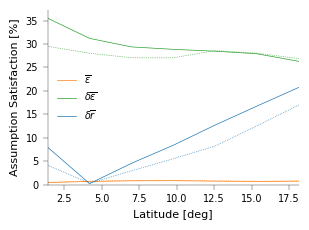

In [195]:
assumption_epsilon_mean = (epsilon_mean[0]*1000/(beta_a1 * temp_adiabat_mean[0]))*100
assumption_epsilon_mean_change = (epsilon_mean[1]-epsilon_mean[0]) * 1000 / (beta_s1 * sf_denom[:, 0]) * 100
assumption_r_mean_change = L_v * q_sat_s/beta_s1 * (r_mean[1]-r_mean[0]) / sf_denom[:, 0] * 100
colors_temp_ft = {'temp_s': default_colors[3], 'r': default_colors[0], 'epsilon': default_colors[2]}

lat = ds[0].lat[lat_use_ind].to_numpy()
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(lat[lat>0], np.abs(assumption_epsilon_mean[lat>0]), color=default_colors[1], label='$\overline{\epsilon}$')
ax.plot(-lat[lat<0], np.abs(assumption_epsilon_mean[lat<0]), color=default_colors[1], linestyle=':')
ax.plot(lat[lat>0], np.abs(assumption_epsilon_mean_change[lat>0]), color=colors_temp_ft['epsilon'], label='$\delta \overline{\epsilon}$')
ax.plot(-lat[lat<0], np.abs(assumption_epsilon_mean_change[lat<0]), color=colors_temp_ft['epsilon'], linestyle=':')
ax.plot(lat[lat>0], np.abs(assumption_r_mean_change[lat>0]), color=colors_temp_ft['r'], label='$\delta \overline{r}$')
ax.plot(-lat[lat<0], np.abs(assumption_r_mean_change[lat<0]), color=colors_temp_ft['r'], linestyle=':')
ax.set_xlim(lat[lat>0][0], lat[lat>0][-1])
ax.set_xlabel('Latitude [deg]')
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_ylabel('Assumption Satisfaction [%]')
ax.legend()
plt.tight_layout()

### $\delta \overline{T_{FT}}$ Breakdown
The latter two approximations are really saying that the approximation $\delta \overline{T_{FT}} \approx \delta \overline{h^{\dagger}}/\beta_{FT1}$ is dominated by changes in $\delta \overline{T_s}$ and so can be simplified to $\delta \overline{T_{FT}} \approx \frac{\overline{\beta_{s1}}}{\beta_{FT1}}\delta \overline{T_s}$.

Without making the two approximations though, we would have: $\delta \overline{T_{FT}} \approx \frac{\overline{\beta_{s1}}}{\beta_{FT1}}\delta \overline{T_s}\left[1 + \frac{L_v \overline{q_s^*}}{\overline{\beta_{s1}}}\frac{\delta \overline{r_s}}{\delta \overline{T_s}} - \frac{\delta \overline{\epsilon}}{\overline{\beta_{s1}} \delta \overline{T_s}}\right]$.

Below I break down the contribution to $\delta \overline{T_{FT}}$. It seems that the $\delta \overline{r_s}$ and $\delta \overline{\epsilon}$ terms oppose each other so making both assumptions is better than making one, and the red line matches the black line well.

Over land, it seems that changes in mean CAPE and mean relative humidity are important.

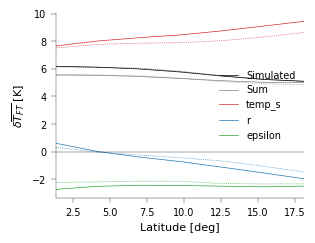

In [200]:
# Choose whether to use beta_ft1 (no assumption on mean CAPE) or beta_a1 (making orange assumption above)
_, _, _, beta_ft1, _, _ = get_theory_prefactor_terms(temp_mean[0, ind_ft], p_surface, pressure_ft_actual)
beta_use = beta_a1
# beta_use = beta_ft1

temp_ft_mean_change_breakdown = {'temp_s': beta_s1/beta_use * sf_denom[:, 0]}
temp_ft_mean_change_breakdown['r'] = temp_ft_mean_change_breakdown['temp_s'] * assumption_r_mean_change/100
temp_ft_mean_change_breakdown['epsilon'] = -temp_ft_mean_change_breakdown['temp_s'] * assumption_epsilon_mean_change/100
temp_ft_mean_change_breakdown_sum = sum(temp_ft_mean_change_breakdown[key] for key in temp_ft_mean_change_breakdown)

save_temp_ft_mean_change_fig = True
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(lat[lat>0], (temp_mean[1, ind_ft] - temp_mean[0, ind_ft])[lat>0], color='k', label='Simulated')
ax.plot(-lat[lat<0], (temp_mean[1, ind_ft] - temp_mean[0, ind_ft])[lat<0], color='k', linestyle=':')
ax.plot(lat[lat>0], temp_ft_mean_change_breakdown_sum[lat>0], color='grey', label='Sum')
ax.plot(-lat[lat<0], temp_ft_mean_change_breakdown_sum[lat<0], color='grey', linestyle=':')
for key in temp_ft_mean_change_breakdown:
    ax.plot(lat[lat>0], temp_ft_mean_change_breakdown[key][lat>0], color=colors_temp_ft[key], label=key)
    ax.plot(-lat[lat<0], temp_ft_mean_change_breakdown[key][lat<0], color=colors_temp_ft[key], linestyle=':')
ax.set_xlim(lat[lat>0][0], lat[lat>0][-1])
ax.set_xlabel('Latitude [deg]')
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_ylabel('$\delta \overline{T_{FT}}$ [K]')
ax.legend()

if save_fig or save_temp_ft_mean_change_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_ft_mean_change_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)